# Extract the features of the interictal epileptiform activity (IEA)

In this notebook we will use the data recorded with an intracranial EEG device in one person with epilepsy. This device records 1) seizures, visible in the EEG as pathological signals evolving in time and 2) interictal epilepform activity (IEA), evanescent electrical discharges produced by the epileptic brain between seizures. We will show how IEA fluctuates cyclically over days and use a wavelet transform to extract the phase of these "multidien" cycles. We will also compute the phase-locking value (PLV) for the locking of the seizures in the multidien phase.

## Import libraries

For these computations we need to load Python libraries, including a wavelet toolbox.


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
from pandas.plotting import register_matplotlib_converters

## Load the data 

We will load data recorded by the EEG device over years in one patient with epilepsy from a CSV file. The first column contains daily timestamps of recordings. The second and third column contain counts of seizures and IEA (i.e. the number of detected waveforms) per day, respectively. The IEA has been normalized by Z-scoring blocks of several weeks of recordings, to account for periods of stable detection settings of the EEG device. 

In [2]:
data = pd.read_csv(r'data/features_day_JE_acausal4.csv')
data[['Time','Seizures','IEA_1']]

,Time,Seizures,IEA_1
0,733972.979167,0,-0.688957
1,733973.979167,0,-0.397765
2,733974.979167,2,-0.045270
3,733975.979167,0,0.537114
4,733976.979167,0,-0.482058
...,...,...,...
535,734507.979167,1,-0.127745
536,734508.979167,0,-0.576691
537,734509.979167,0,-0.639701
538,734510.979167,0,-0.663330


## Raw data

We have two types of raw data 1) Seizures and 2) IEA. 
#### Seizures
We first plot the daily seizure counts over time. 

<IPython.core.display.Javascript object>


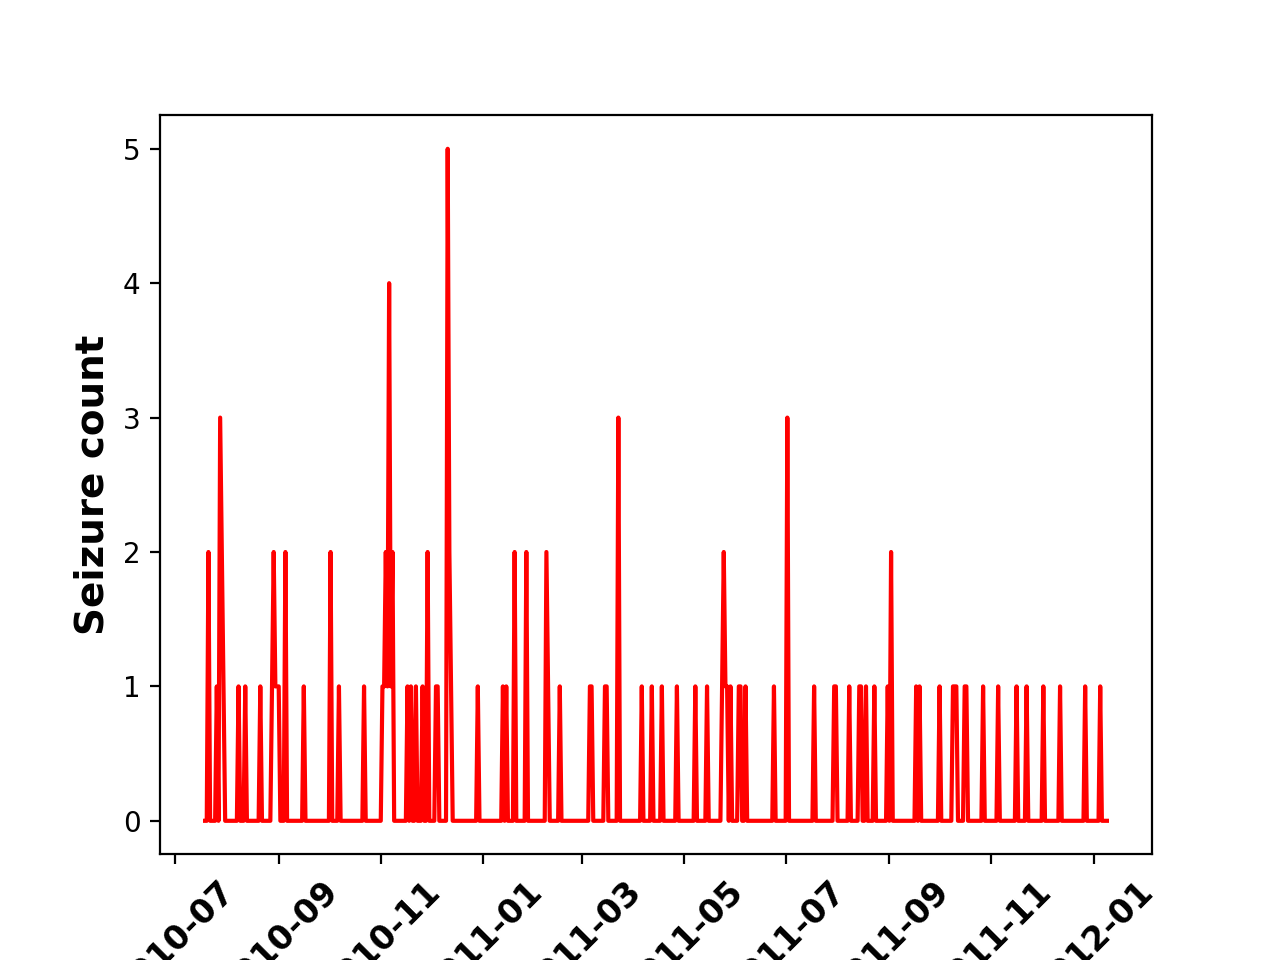

In [3]:
SeizJE = data.Seizures
TimeDate = data.Time.astype(int).map(dt.datetime.fromordinal)
register_matplotlib_converters()

plt.figure()
plt.plot(TimeDate, SeizJE, 'r')
plt.ylabel('Seizure count', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.show();

#### Figure
The figure shows counts of seizures over time. It is difficult to discern any type of rhythmicity when looking only at this data. 

### Interictal epileptiform activity (IEA)
We then plot the (already normalized) average daily IEA over time along with time of occurrence of seizures. 

<IPython.core.display.Javascript object>


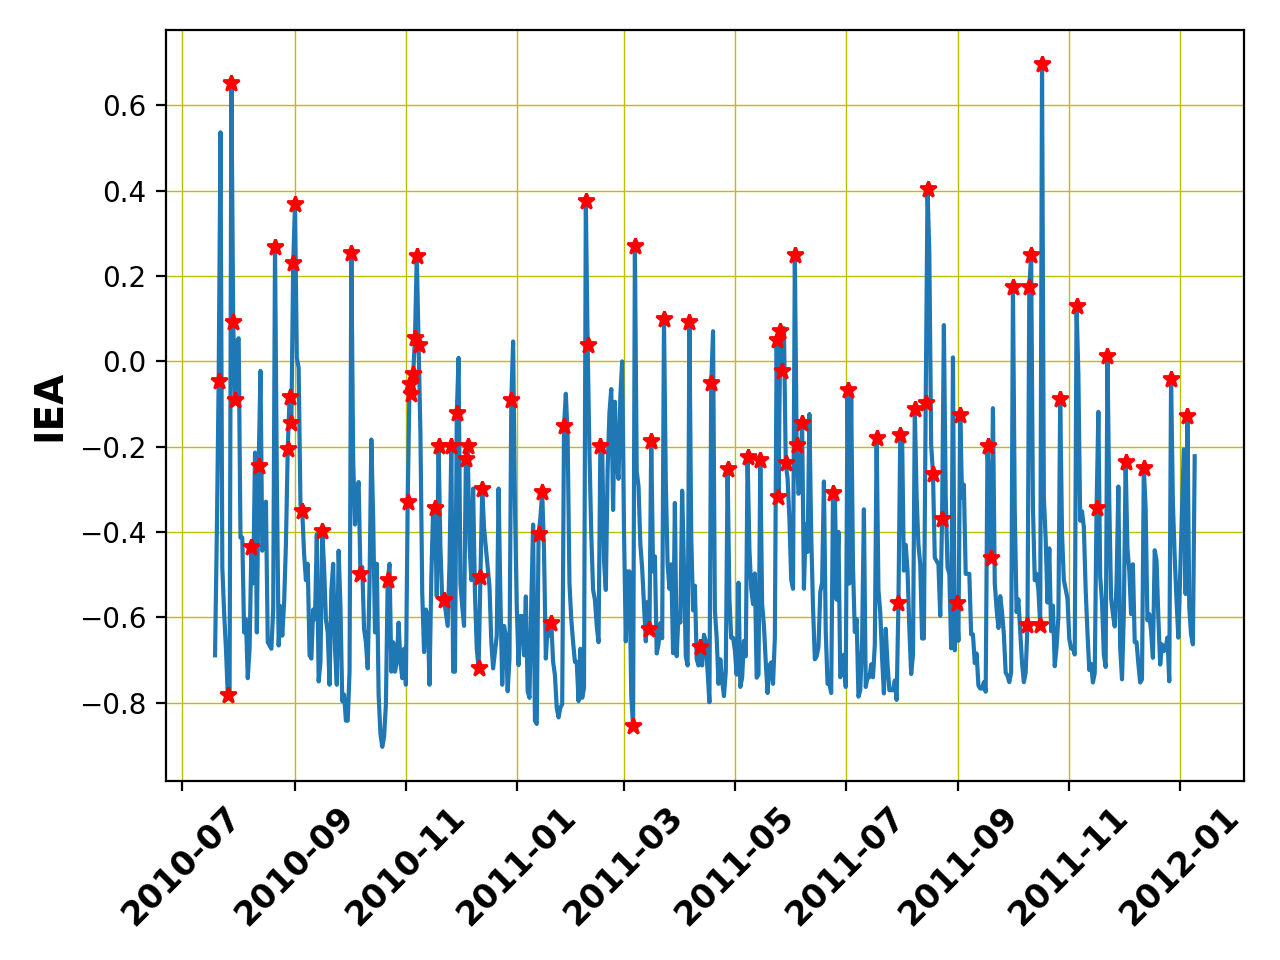

In [4]:
PosSeizJE = np.where(data.Seizures>=1)
TimeDate = data.Time.astype(int).map(dt.datetime.fromordinal)
register_matplotlib_converters()

plt.figure()
plt.plot(TimeDate,data.IEA_1)
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.plot(TimeDate.iloc[PosSeizJE], data.IEA_1.iloc[PosSeizJE],'r*')
#plt.xlim((4900, 5100))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.tight_layout()
plt.show();

#### Figure
The figure shows the fluctuations of IEA (averaged over one day) over time. We observe that IEA has a periodic behaviour. Use the interactive tools of the plot to display one year at a time, then only one month (zoom, empty square). You can travel on the x-axis using the directional cross. Seizures are plotted as red stars. Pay attention to where in the IEA cycle they tend to occur. In the next sections, we will characterize this phasic relationship between seizures (a point event) and IEA (the continuous variable). We will later use it for forecasting.

## Wavelet transform

As we observe, fluctuations in IEA are periodic, but not necessarily stationary. To capture the instantaneous changes in time, we use a Morlet wavelet tranform that can evaluate power and phase of different rhythms at each time-point. We focus on multidien cycles which are here defined between 4-45 days. We start by defining the periods to be evaluated.

In [5]:
fs = 1
scales = np.arange(1,45,0.5)
frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / 1
print(1/frequencies)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5
 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5]


#### Detail
The wavelet transform evaluates power and phases for a number of scaled version of the mother wavelet (here the Morlet wavelet). Each mother wavelet has a given Fourrier conversion factor to transform a scale into frequency. For the Morlet wavelet the Fourrier factor is 1.03. 

<IPython.core.display.Javascript object>


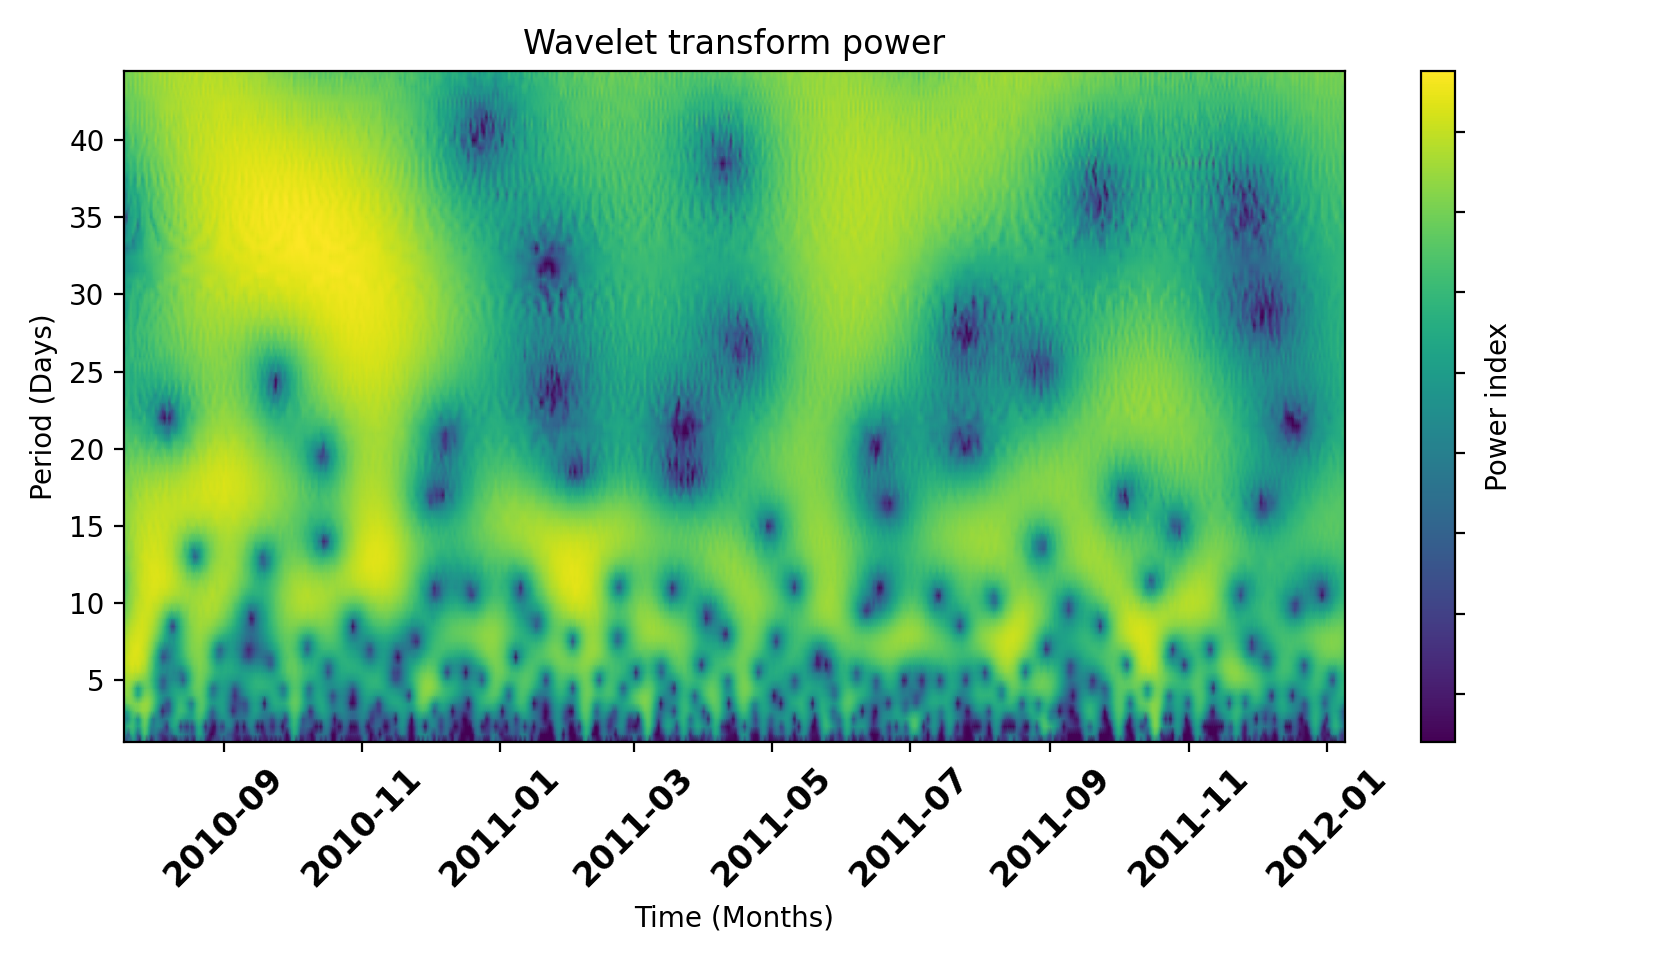

In [6]:
[coefficients_IEA, frequencies] = pywt.cwt(data.IEA_1, scales,'cmor1.5-1.0',1)
power_IEA = np.log((abs(coefficients_IEA)))
Periods = 1/frequencies

plt.figure(figsize=(8.4, 4.8))
c=plt.pcolormesh(TimeDate,Periods,power_IEA,cmap='viridis', shading='gouraud',vmin = .6*power_IEA.min(), vmax = power_IEA.max())
plt.title('Wavelet transform power')
cbar = plt.colorbar(c)
cbar.set_label('Power index')
cbar.ax.set_yticklabels([])
plt.ylabel('Period (Days)')
plt.xlabel('Time (Months)')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.tight_layout()
plt.show();

#### Figure
In this spectrogram (also called scalogram), we see the wavelet power over time for different periods (y-axis). The power has been logged for visual rendering. One can see a band of power between 7 and 15 days, which is relatively stable. We also see other blobs of power around 35 days. 

## Peak periodicity

From the above spectrogram, we can extract the peak periodicity by looking at the average periodogram and its peaks. 

<IPython.core.display.Javascript object>


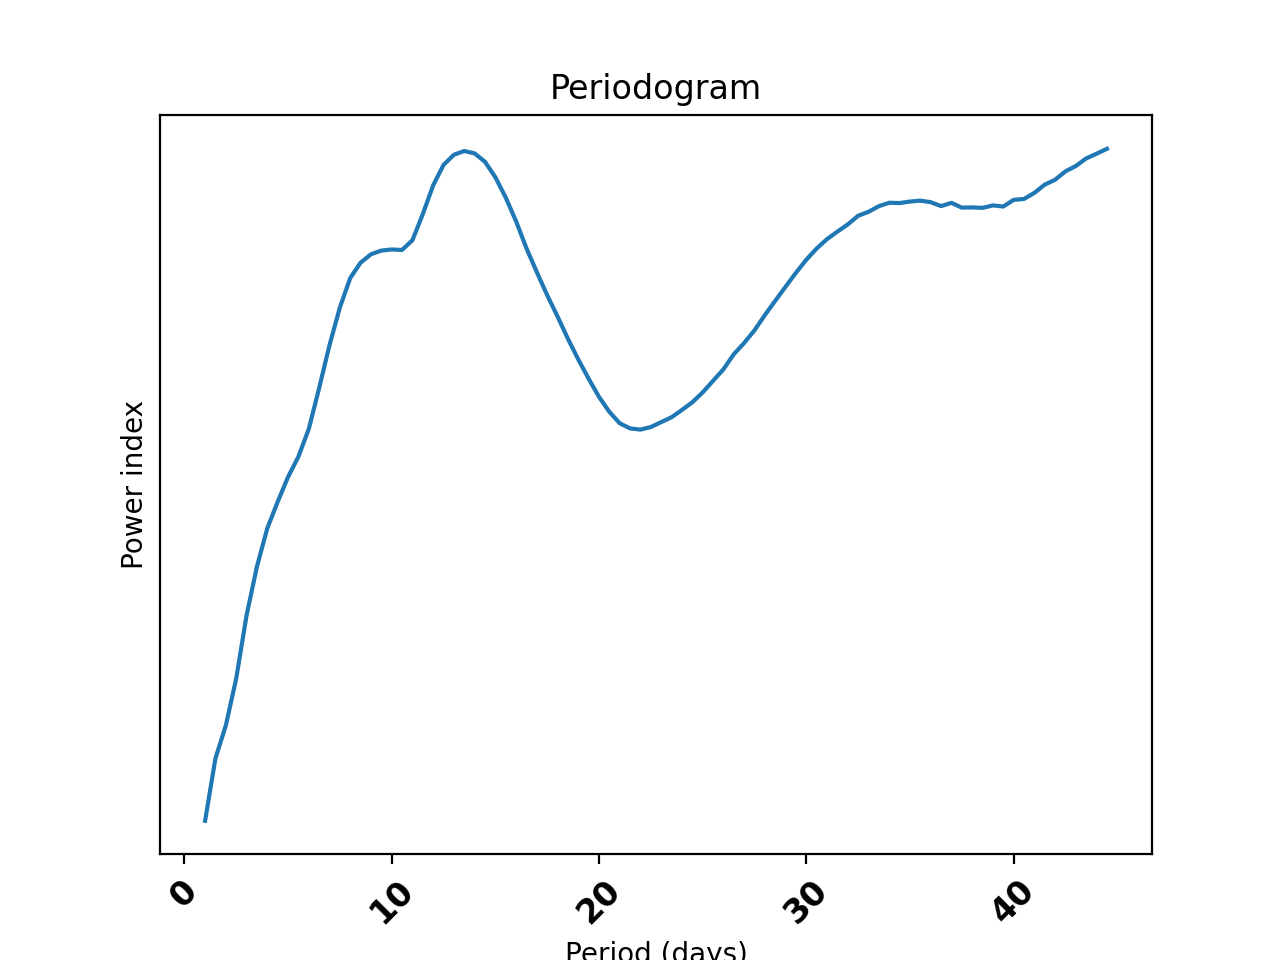

In [7]:
# Periodogram
power_IEA = (abs(coefficients_IEA))
Av_power = np.mean(power_IEA, axis=1)

plt.figure()
plt.title('Periodogram')
plt.plot(Periods, Av_power)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Period (days)')
plt.ylabel('Power index')
plt.yticks([])
plt.show();

#### Figure
As we previously saw in the spectrogram, we here see a distinct peak around 14 days and other secondary peaks 

We now find the peaks of this periodogram.

<IPython.core.display.Javascript object>


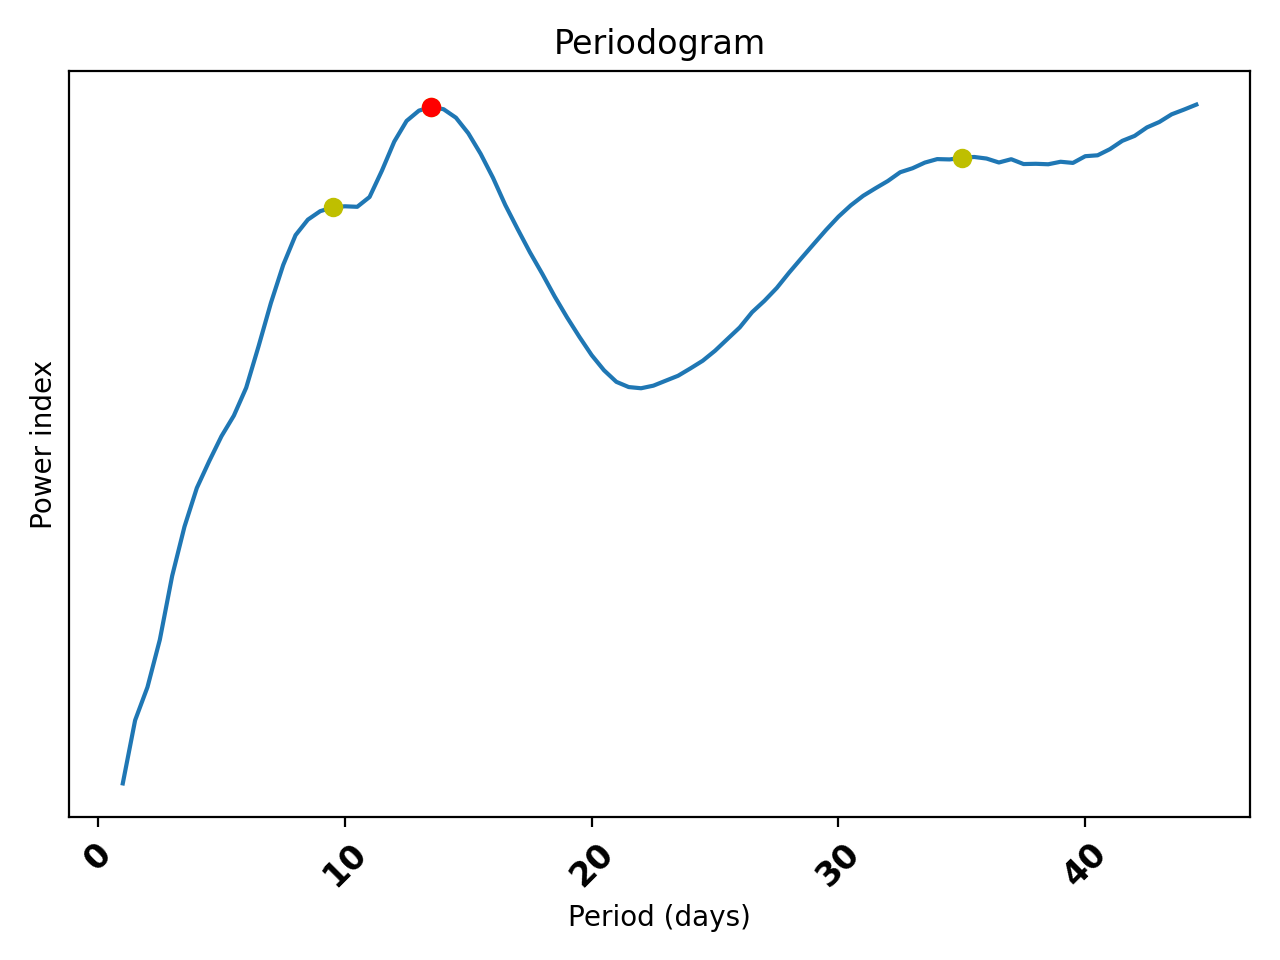

Peak of the periodogram = 14


In [8]:
# peak frequency 
sm_Av_power = signal.savgol_filter(Av_power, 11, 7)  
# we smooth the periodogram to find its peak with a window size of 11 and a  polynomial fit of order 7
peaks, properties = signal.find_peaks(sm_Av_power,np.mean(sm_Av_power)) #We find the few peaks of the periodogram
hights = properties['peak_heights']
Peak_period = (Periods[peaks[np.argmax(hights)]])  # We take the peak-periodicity with the highest power
plt.figure()
plt.title('Periodogram')
plt.plot(Periods, Av_power)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Period (days)')
plt.ylabel('Power index')
plt.yticks([])
#plt.plot(Periods[peaks[0:3]],Av_power[peaks[0:3]],'yo')
plt.plot(Periods[peaks], Av_power[peaks],'yo')

plt.plot(Periods[peaks[1]], Av_power[peaks[1]],'ro')
plt.tight_layout()
plt.show()
print('Peak of the periodogram = %0.0f' %Peak_period);

#### Figure
Here we found the peak periodicities by averaging wavelet power over years. 

We now plot the phase of the multidien rhythms for the peak periodicity of 14 days, with some bandwitdh around to account for non-stationarity in the rhythm.

Extracting phase between 9 and 18 days


<IPython.core.display.Javascript object>


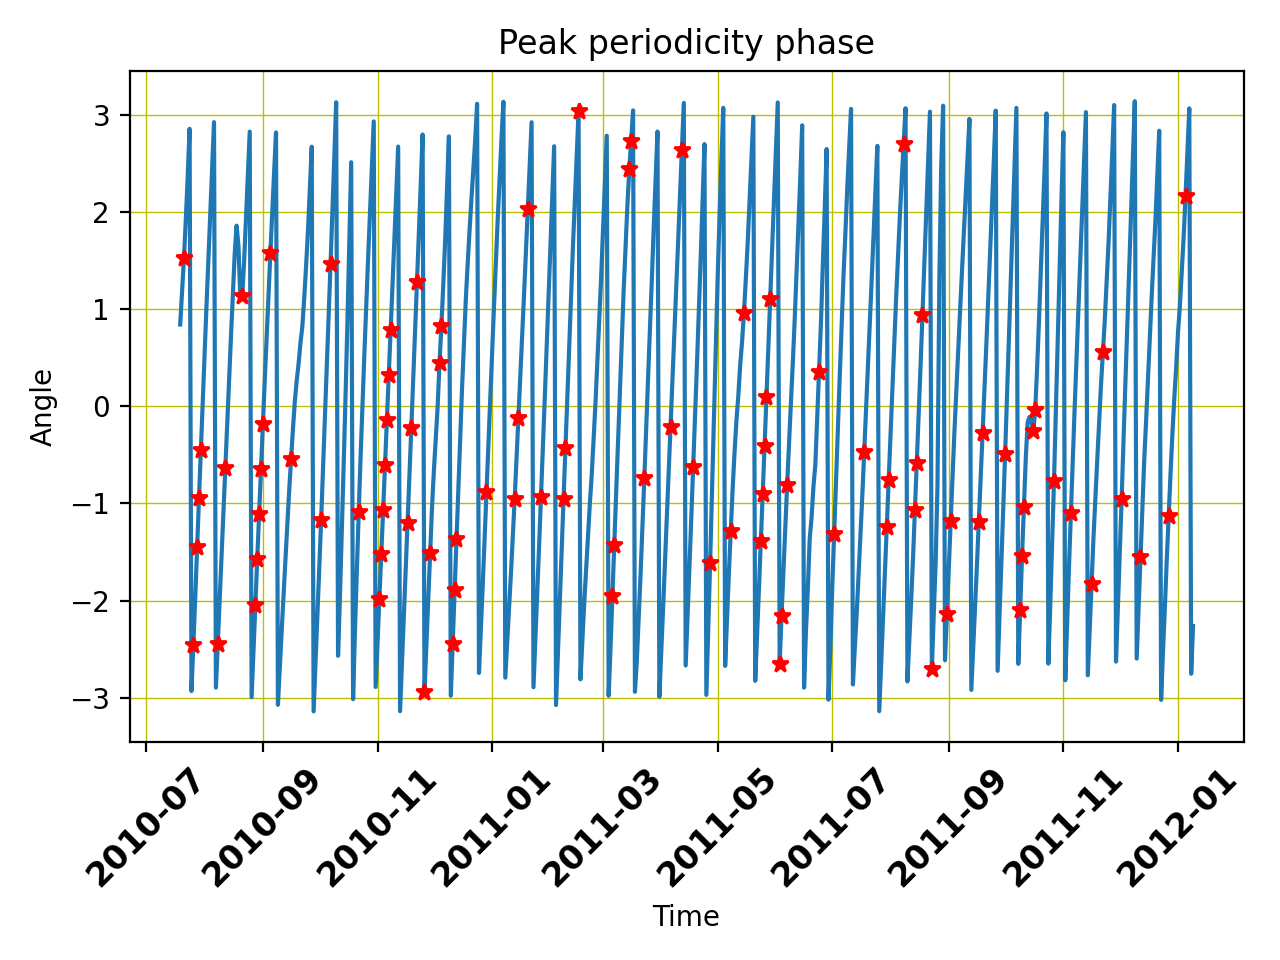

In [9]:
# take the peak of the periodogram
max_Pk = peaks[np.argmax(hights)]
max_Pk_inf = (round(Peak_period-.33*Peak_period))
max_Pk_sup = (round(Peak_period+.33*Peak_period))

idx_min = (np.abs(Periods - max_Pk_inf)).argmin()
idx_max = (np.abs(Periods - max_Pk_sup)).argmin()

print('Extracting phase between %0.0f and %0.0f days' %(max_Pk_inf,max_Pk_sup))


angle_peak_IEA=np.angle(coefficients_IEA[idx_min:idx_max,:].mean(axis=0))
#angle_peak_IEA=np.angle(coefficients_IEA[max_Pk,:])

plt.figure()
plt.title('Peak periodicity phase')
plt.plot(TimeDate,angle_peak_IEA)
plt.plot(TimeDate.iloc[PosSeizJE],angle_peak_IEA[PosSeizJE],'r*')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.tight_layout()
plt.show();

#### Figure 
This figure represents the phase of an about 15 day cycle oscillating between -pi and +pi. One can see the phase in which seizures tend to occur. 

## Phase locking

We compute the phase locking value (PLV) of the seizures on the phase of the multidien cycle defined by fluctuations in IEA.

In [10]:
def PLVcalculation(phase):
    z=sum(np.exp(1j*phase))/len(phase)
    PLV=np.abs(z)
    Psi=np.angle(z)
    return PLV,Psi

phase_Sz = angle_peak_IEA[PosSeizJE] # Phases at which seizures occur
PLV,Psi=PLVcalculation(phase_Sz)     # Extract PLV (length of vector) and Psi (average angle)

We plot the polar histogram along with the mean resultant vector. 

<IPython.core.display.Javascript object>


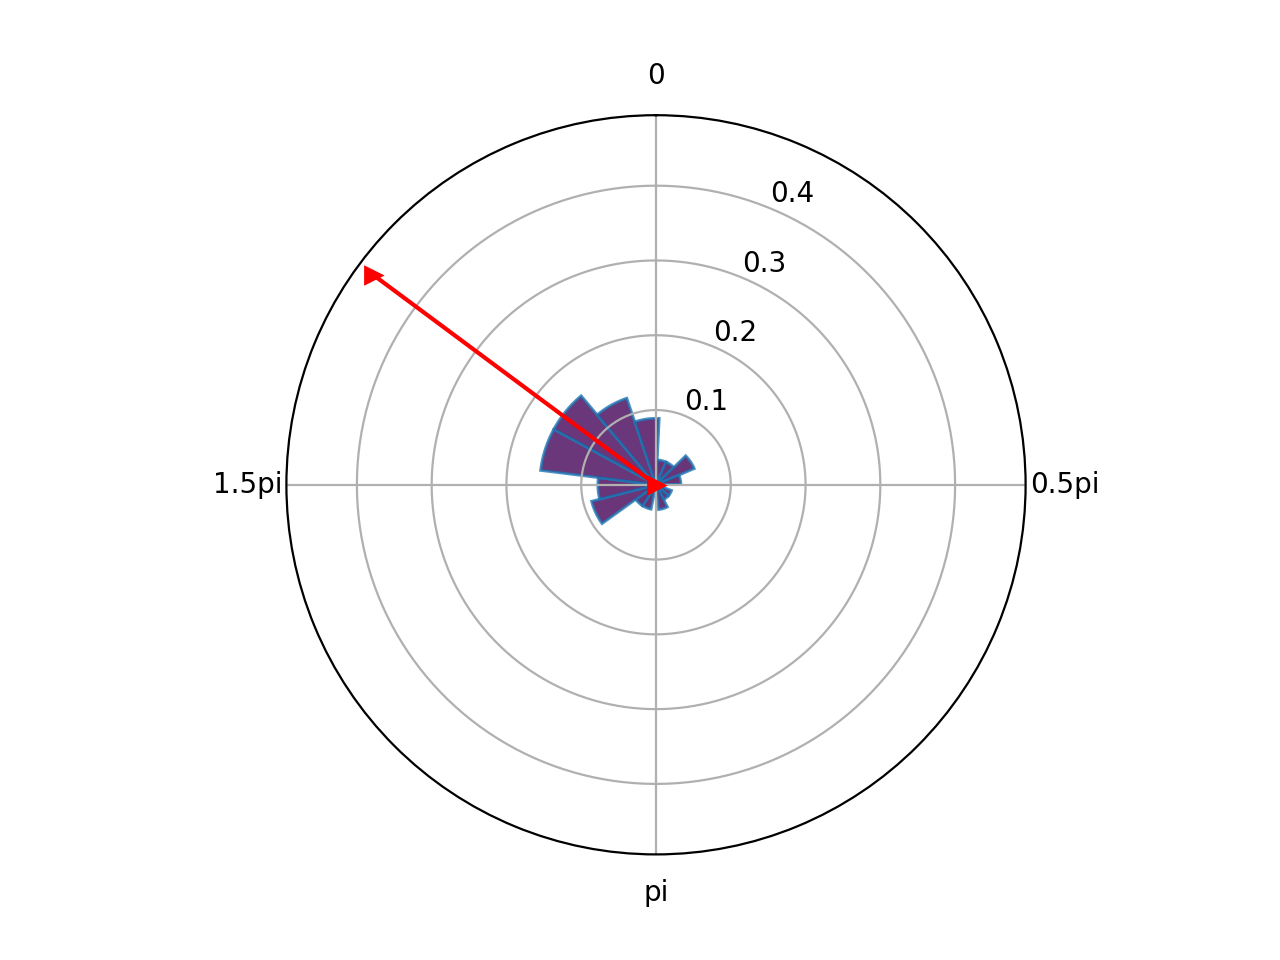

In [11]:
bins=16
num, bins = np.histogram(angle_peak_IEA[PosSeizJE], bins=bins)
widths = np.diff(bins)
radius = num/len(PosSeizJE[0])

# Plot the data
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                 edgecolor='C0', fill=True, linewidth=1,alpha=0.3)

lines, labels = plt.thetagrids(range(0, 360, 90), ('0', '0.5pi', 'pi', '1.5pi'))
for r, bar in zip(radius, patches):
    bar.set_facecolor(plt.cm.viridis(r / 10.))
    bar.set_alpha(0.8)
ax.plot([0 ,Psi],[0,PLV],'r->')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1) 
plt.show();

#### Figure
In this circular plot, the histogram in blue represent proportion of seizure occurrence at different phases. The red vector is the average resultant vector. It would have a length (PLV) of zero if the circular distribution of seizures was uniform. It would have a length of 1 if the seizures occurred exactly at the same multidien phase each time. A PLV of 0.4 as shown here is a strong phase-locking effect for a biological process. 